In [1]:
from pathlib import Path
from pybedtools import BedTool
import pandas as pd
old_output_dir = Path('/projects/ps-yeolab5/ABC_chisq_peaks/')
rep1 = 'Dan_multiplex1_K562_rep6'


In [2]:
def get_sig_peak(rbp, rep, pval_cutoff = 3, fc_cutoff = 3):
    b = BedTool(old_output_dir/ rep/f'{rep}_{rbp}.peaks.normed.compressed.bed')
    b = b.filter(
        lambda region: float(region[3])>pval_cutoff and float(region[4])>fc_cutoff).sort().saveas()
    #print(b[0])
    b = b.merge(
        s = True, d = 5, o = ['max', 'max', 'distinct'], c = [4,5,6]).saveas()
    return b


In [3]:
window_bed = BedTool('/projects/ps-yeolab4/software/skipper/1.0.0/bin/skipper/annotations/gencode.v38.annotation.k562_totalrna.gt1.tiled_partition.features.tsv.gz')
window_col = pd.read_csv(window_bed.fn, sep = '\t', nrows = 5).columns.tolist()

In [4]:
clipper_col = ['chr', 'start', 'end', '-log10p', 'log2fc', 'strand']

In [6]:
def label_windows():
    rbps = [f.name.split('.')[0].split('_')[-1] for f in (old_output_dir/rep1).glob('*.peaks.normed.compressed.bed')]
    
    data = []
    count = []
    for rbp in rbps:
        reproducible_peak = get_sig_peak(rbp, rep1)
        window = window_bed.intersect(reproducible_peak, s = True, u = True, F = 0.5).to_dataframe(names = window_col)
        
        window[rbp] = True
        data.append(window.set_index('name')[rbp])
        type_cnt = window['feature_type_top'].value_counts()
        type_cnt.name = rbp
        count.append(type_cnt)
    return pd.concat(data, axis = 1).fillna(False),  pd.concat(count, axis = 1).fillna(0)

In [7]:

rbps = [f.name.split('.')[0].split('_')[-1] for f in (old_output_dir/rep1).glob('*.peaks.normed.compressed.bed')]

pv_data = []
fc_data = []
count = []
for rbp in rbps:
    reproducible_peak = get_sig_peak(rbp, rep1, pval_cutoff = 0, fc_cutoff=-100)
    window = window_bed.intersect(reproducible_peak, s = True, wb = True, F = 0.5).to_dataframe(
        names = window_col+['clipper_'+c for c in clipper_col])
    
    best_pval = window.groupby(by = 'name')['clipper_-log10p'].max()
    best_l2fc = window.groupby(by = 'name')['clipper_log2fc'].max()
    
    best_pval.name = rbp
    best_l2fc.name = rbp
        
    
    pv_data.append(best_pval)
    fc_data.append(best_l2fc)
    
pv_data = pd.concat(pv_data, axis = 1).fillna(0) 
fc_data = pd.concat(fc_data, axis = 1).fillna(-100)

In [8]:
windows, cnt = label_windows()

In [9]:
cnt

,IGF2BP2,PRPF8,SF3B4,DDX3,LIN28B,RBFOX2,EIF3G,ZC3H11A,FAM120A,PUM2
UTR3,1332.0,127,125.0,19.0,903.0,123.0,14.0,526.0,8632.0,191.0
CDS,670.0,990,219.0,254.0,2646.0,19.0,89.0,394.0,46.0,37.0
INTRON,56.0,81,144.0,57.0,811.0,3293.0,66.0,164.0,322.0,29.0
EXON_LNCRNA,53.0,168,167.0,27.0,76.0,69.0,10.0,35.0,128.0,15.0
CDS_STOP,47.0,101,12.0,14.0,188.0,6.0,3.0,70.0,19.0,3.0
UTR5,25.0,71,93.0,995.0,156.0,27.0,422.0,16.0,21.0,3.0
CDS_START,17.0,33,9.0,326.0,169.0,2.0,50.0,3.0,6.0,2.0
EXON_MRNA,14.0,849,830.0,9.0,54.0,163.0,3.0,22.0,19.0,3.0
SS5_PROX,5.0,47,37.0,5.0,66.0,444.0,11.0,11.0,24.0,4.0
SSB_PROX,3.0,23,118.0,2.0,18.0,134.0,4.0,3.0,5.0,3.0


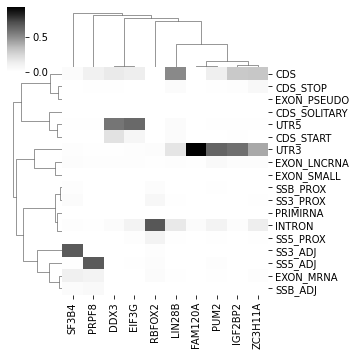

In [10]:
import seaborn as sns
sns.clustermap(cnt.div(cnt.sum(axis = 0), axis = 1), metric = 'correlation', cmap = 'Greys', figsize = (5,5))

In [11]:
windows.to_csv(f'{rep1}.window.csv')


In [12]:
pv_data.to_csv(f'{rep1}.best_pval_perwindow.csv')
fc_data.to_csv(f'{rep1}.best_fc_perwindow.csv')

In [13]:
cnt.to_csv(f'{rep1}.window.feature_counts.csv')